##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 전이 학습으로 꽃 분류하기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_feature_vector"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

아름다운 꽃을 보고 어떤 꽃인지 궁금한 적이 있지 않으셨나요? 여러분이 처음은 아닐 테니, 사진에서 꽃의 유형을 식별하는 방법을 만들어보겠습니다!

이미지를 분류하기 위해서는 *컨볼루셔널 신경망*이라고 하는 특정 유형의 *심층 신경망*이 특히 강력한 힘을 발휘하는 것으로 입증되었습니다. 그러나 현대의 컨볼루셔널 신경망에는 수백만 개의 매개변수가 있습니다. 처음부터 훈련하려면 레이블이 지정된 많은 훈련 데이터와 많은 컴퓨팅 성능(수백 시간 이상의 GPU 시간)이 필요합니다. 레이블이 붙은 사진이 약 3천장 밖에 없고 훨씬 적은 시간만 소비하기를 원하므로 더 현명하게 판단해야 합니다.

우리는 *전이 학습(transfer learning)*이라는 기술을 사용하여 사전 훈련된 네트워크(약 백만 개의 일반 이미지에 대해 훈련됨)를 사용하여 특성을 추출하고 꽃 이미지를 분류하는 고유한 작업을 위해 맨 상층에서 새 레이어를 훈련합니다.


## 설정


In [2]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

2022-12-14 20:12:22.988962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:12:22.989057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:12:22.989066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Instructions for updating:
non-resource variables are not supported in the long term


## 꽃 데이터세트

꽃 데이터세트는 5개의 가능한 클래스 레이블이 있는 꽃 이미지로 구성됩니다.

머신러닝 모델을 훈련할 때 데이터를 훈련 및 테스트 데이터세트로 분할합니다. 훈련 데이터에서 모델을 훈련한 다음 모델이 본 적이 없는 데이터(테스트 세트)에서 모델이 얼마나 잘 동작하는지 평가합니다.

훈련 및 테스트 예제를 다운로드하고(시간이 걸릴 수 있음) 훈련 및 테스트 세트로 나눕니다.

다음 두 개의 셀을 실행합니다.

In [3]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [4]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


## 데이터 탐색하기

꽃 데이터세트는 꽃 이미지로 레이블이 지정된 예들로 구성됩니다. 각 예에는 JPEG 꽃 이미지와 클래스 레이블(꽃의 종류)이 포함되어 있습니다. 레이블과 함께 몇 개의 이미지를 표시해 보겠습니다.

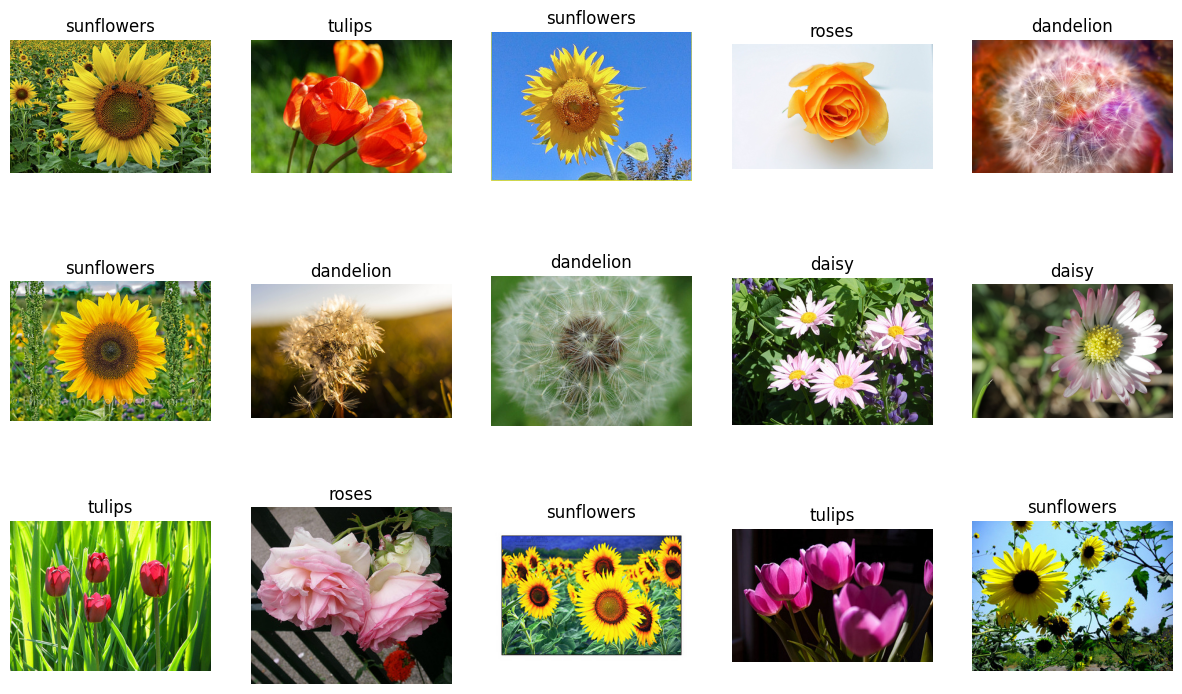

In [5]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 15 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

## 모델 빌드하기

[TF-Hub](https://tensorflow.org/hub) 이미지 특성 벡터 모듈을 로드하고, 여기에 선형 분류자 스택을 놓고 훈련 및 평가 연산을 추가하겠습니다. 다음 셀은 모델과 훈련을 설명하는 TF 그래프를 빌드하지만 훈련을 실행하지는 않습니다(다음 단계에서 실행할 예정).

In [6]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)


def decode_and_resize_image(encoded):
  decoded = tf.image.decode_jpeg(encoded, channels=3)
  decoded = tf.image.convert_image_dtype(decoded, tf.float32)
  return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.
features = image_module(batch_images)


def create_model(features):
  """Build a model for classification from extracted features."""
  # Currently, the model is just a single linear layer. You can try to add
  # another layer, but be careful... two linear layers (when activation=None)
  # are equivalent to a single linear layer. You can create a nonlinear layer
  # like this:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer


# For each class (kind of flower), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tmpfs/tmp/ipykernel_15216/2879154528.py:34: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)


## 네트워크 훈련하기

이제 모델을 빌드했으므로 모델을 훈련하고 테스트세트에서 어떻게 동작하는지 살펴보겠습니다.

In [7]:
# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 100 #@param {type: 'integer'}
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 #@param {type: 'integer'}
# How often to evaluate the model performance.
EVAL_EVERY = 10 #@param {type: 'integer'}

def get_batch(batch_size=None, test=False):
  """Get a random batch of examples."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Get the one hot encoding vector for the example."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Get a random batch of training examples.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Run the train_op to train the model.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Get a batch of test examples.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Evaluate how well our model performs on the test set.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 22.15%


Test accuracy at step 10: 48.78%


Test accuracy at step 20: 63.04%


Test accuracy at step 30: 71.20%


Test accuracy at step 40: 76.49%


Test accuracy at step 50: 75.82%


Test accuracy at step 60: 79.08%


Test accuracy at step 70: 78.40%


Test accuracy at step 80: 79.76%


Test accuracy at step 90: 75.41%


Test accuracy at step 99: 77.85%


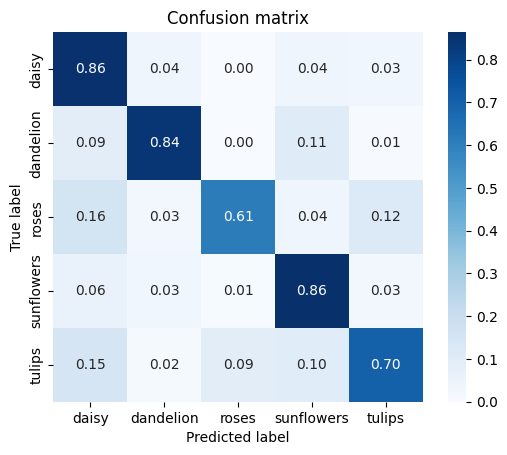

In [8]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

## 잘못된 예측

여기서 빌드한 모델이 잘못 동작하는 테스트 예를 자세히 살펴보겠습니다.

- 테스트 세트에 레이블이 잘못 지정된 예가 있습니까?
- 테스트 세트에 잘못된 데이터가 있습니까? 실제로 꽃 사진이 아닌 이미지가 있습니까?
- 모델이 실수한 이유를 이해할 수 있는 이미지가 있습니까?

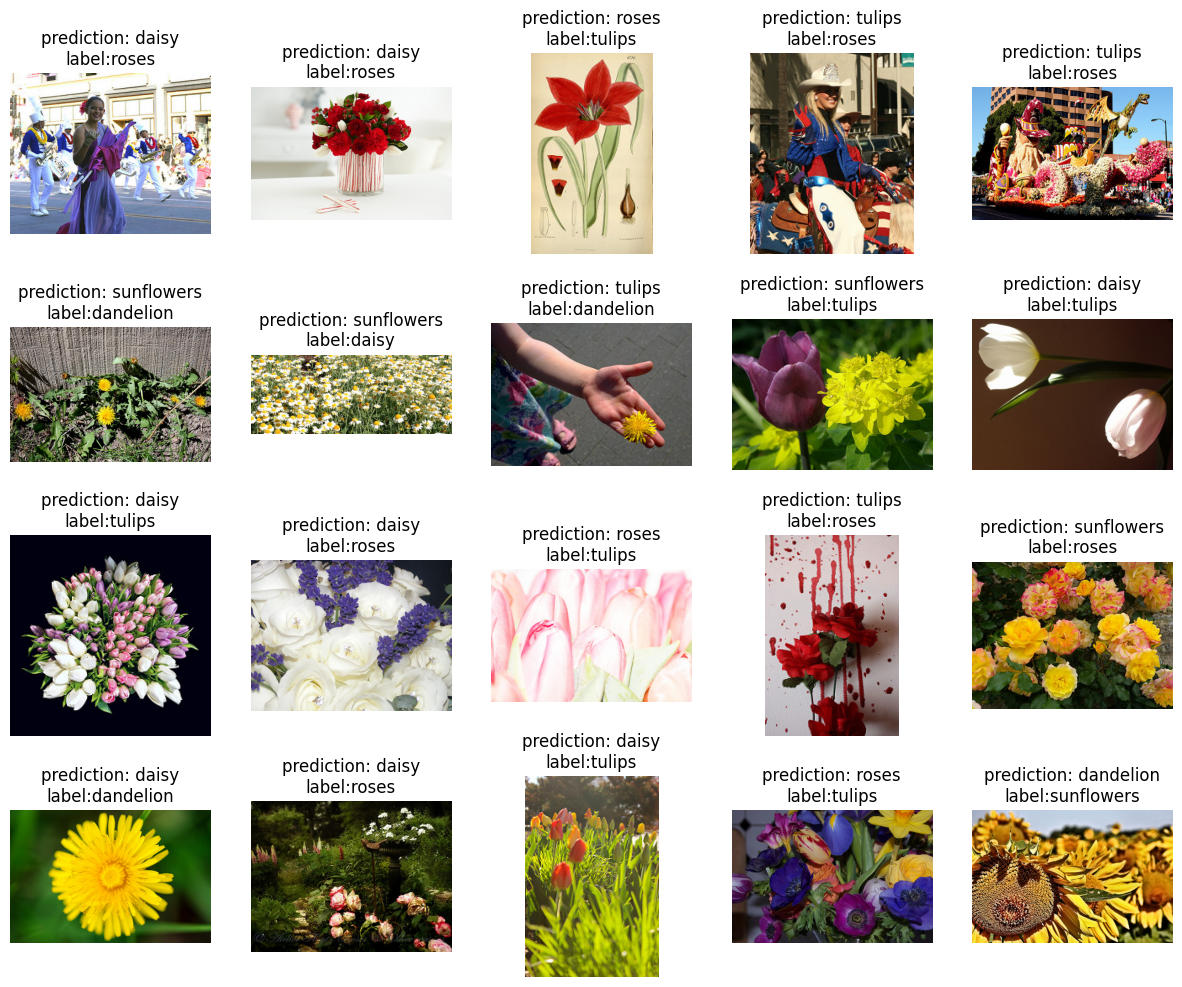

In [9]:
incorrect = [
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])

## 연습: 모델을 개선하세요!

앞서 기준 모델을 훈련했습니다. 이제 더 높은 정확성을 얻기 위해 모델을 개선해 보겠습니다(변경 시 셀을 다시 실행해야 함).

### 연습 1: 다른 이미지 모델을 사용해 봅니다.

TF-Hub에서 몇 가지 다른 이미지 모델을 간단히 시도해 볼 수 있습니다. `hub.Module()` 호출에서 `"https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2"` 핸들을 다른 모듈의 핸들로 대체하고 모든 코드를 다시 실행하기만 하면 됩니다. [tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector)에서 사용 가능한 모든 이미지 모듈을 볼 수 있습니다.

다른 [MobileNet V2 모듈](https://tfhub.dev/s?module-type=image-feature-vector&network-architecture=mobilenet-v2) 중 하나를 선택하는 것이 좋습니다. MobileNet 모듈을 포함한 많은 모듈은 1백만 개 이상의 이미지와 1000개의 클래스가 포함된 [ImageNet 데이터세트](https://www.tensorflow.org/datasets/catalog/imagenet2012)에서 훈련되었습니다. 네트워크 아키텍처를 선택하면 속도와 분류 정확성 사이에서 균형이 유지됩니다. MobileNet 또는 NASNet Mobile과 같은 모델은 빠르고 작으며 Inception 및 ResNet과 같은 보다 전통적인 아키텍처는 정확성을 위주로 설계되었습니다.

보다 큰 Inception V3 아키텍처의 경우, 고유한 작업에 더 가까운 도메인에서 사전 훈련하는 이점을 모색할 수도 있습니다. 식물과 동물의 [iNaturalist 데이터세트에서 훈련한 모듈](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1)로 사용할 수도 있습니다.

### 연습 2: 숨겨진 레이어를 추가합니다.

추출된 이미지 특성과 선형 분류자 사이에 숨겨진 레이어 스택을 넣습니다(위의 `create_model()` 함수). 예를 들어 100개의 노드가 있는 비선형의 숨겨진 레이어를 만들려면 단위를 100으로 설정하고 활성화를 `tf.nn.relu`로 설정하여 [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/compat/v1/layers/dense)를 사용합니다. 숨겨진 레이어의 크기를 변경하면 테스트 정확성에 영향을 미칩니까? 두 번째 숨겨진 레이어를 추가하면 정확성이 개선됩니까?

### 연습3 : 하이퍼 매개변수를 변경합니다.

*훈련 스텝 수*를 늘리면 최종 정확성이 개선됩니까? 모델이 더 빠르게 수렴하도록 *학습률을 변경*할 수 있습니까? 훈련 *배치 크기*가 모델의 성능에 영향을 미칩니까?

### 연습 4: 다른 옵티마이저를 사용해 봅니다.

기본 GradientDescentOptimizer를 더 정교한 [최적화 프로그램](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/AdagradOptimizer) (예 : [AdagradOptimizer)으로](http://ruder.io/optimizing-gradient-descent/) 교체하십시오. 모델 학습에 차이가 있습니까? 다양한 최적화 알고리즘의 이점에 대해 자세히 알아 보려면 <a>이 게시물을</a> 확인하십시오.

## 더 알고 싶습니까?

이 튜토리얼의 고급 버전에 관심이 있다면 TensorBoard를 사용하여 훈련을 시각화하는 과정을 안내하는 [TensorFlow 이미지 재훈련 튜토리얼](https://www.tensorflow.org/hub/tutorials/image_retraining), 이미지 왜곡을 이용한 데이터세트 확대와 같은 고급 기술, 고유한 데이터세트에서 이미지 분류자를 학습하기 위해 꽃 데이터세트를 교체하는 방법에 대해 알아보세요.

[tensorflow.org](http://tensorflow.org)에서 TensorFlow에 대해 자세히 알아보고 [tensorflow.org/hub](https://www.tensorflow.org/hub/)에서 TF-Hub API 설명서를 참조할 수 있습니다. 더 많은 이미지 특성 벡터 모듈 및 텍스트 임베딩 모듈을 포함하여 [tfhub.dev](http://tfhub.dev)에서 사용 가능한 TensorFlow 허브 모듈을 찾아보세요.

빠르게 진행되는 Google의 머신러닝 실무 개요 과정인 [머신러닝 집중 과정](https://developers.google.com/machine-learning/crash-course/)을 확인해 보세요.